In [1]:
from data_loader import read_json_as_df

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

pd.options.display.max_colwidth = 1000

In [2]:
train_df = read_json_as_df('clpsych16-train.json')
test_df = read_json_as_df('clpsych16-test.json')

In [3]:
train_df[train_df.priority == 'escalate']

,text,priority
7,"Redhead: aaaaarrrrgggg getting really sick of this hypomania. When will this end. getting so agitated, bored. And its raining so I can't even get out for a walk to calm down. what to do. Its starting to make me feel unsafe... sorry for being so negative again",escalate
24,"negative: feeling like useless effed up idiot, and I haven't felt this bad in a while. Since I last thought about suicide. pos: i can pull through i just have to figure out how",escalate
58,"Neg: Feeling a bit fragile today. Kinda like there is too much going on inside my head to fully understand. Wanting to just live my life with only me running it for once. Feeling controlled by my parents, feeling like I can't stand up to them and tell them to back off, to lay off the expectations, to lay off me wanting to do thiings for them, mum especially. I'm just getting really tired of never being able to have time alone for myself to figure things out myself. Wanting to move out already! Pos: There is a lot going on inside my head right now, I am going to try some journaling later tonight - when I lay on the ground and throw out millions of coloured pens and textas to expres myself! I'm not sure on the whole parent thing, I'll think of some strategiest o try in my journalling. I am looking at moving out at the end of the year. I need that time to find my feet. &nbsp; Neg: Felt really anxious when running into a parent from the last centre I did prac at (she's also a psycholog...",escalate
107,She's very depressed and always wnats to die. I'm pretty scared and I try to help but deep down I'm pretty useless for helping.Any good tips? Because she likes to talk to me because i'm nice to her and doesn't judge her.&nbsp;,escalate
113,Thanks for all the tips. BUT what if one day she has enough and I can't do anything to save her...,escalate
117,Negative: back in the stupid hospital. I can't do this anymore Positive: ? Negative: one of the other patients is really getting to me Positive: taken myself away and listening to music outside to calm down Negative: I don't feel like I can go on anymorePositive: one moment at a time,escalate
131,I don't know I really don't know.....I'm emotionally broken at this point &nbsp; &nbsp; I don't care about myself or what happens to me. I'm expendable &nbsp; I don't think I'll go back to square one but the path is just as bad &nbsp; I just don't know....I'm sorry,escalate
134,"No but I am pretty friggin sick of my entire life at this point and my existence. I'm an 18 year old with only a few years of McDonalds on his resume, no friends, biggest joy in life is leaving the house to do any camera activites, can't write essays worth a damn, is scared of the dark (and outside world for that matter) Can't stay in environments all alone and feels like nightmares are important clues to mental healthI feel like no one goves a crap about me. I bolted from my house in tears and nobody followed me or asked if I was alright when I returned. They knew I was leaving as I cried out. It was like it didn't happen.I could vanish and it wouldn't matter . I'm sorry for that. It's hurting inside so much The medication is no longer helping, I'm too depressed.",escalate
155,"Neg: Feeling extremeley tired each morning. It's getting to the point I'm contemplating ringing in sick to aviod getting up. Pos: Despite the tiredness, I've bee getting up and going to work, because I know I need to face the world. &nbsp; Neg: Keep having thoughts to end it all, pretty much every second day I'm trying to find reasons to live. I just don't know how much longer I can take it all. It all feels like way too much pressure. I don't know how to ease any of it! Pos: I'm managing to delay myself from takin any actions. Despite the feelings, I've not hurt myself in probably nearly a week! I'm fighting each thought. &nbsp; Neg: TAFE feels like too much right now. I'm NOT enjoying the course, I'm NOT enjoying LIFE. I'm struggling to even find motivation to get any of

Mean: 411.0960929250264 
Median: 218.0 
Std: 600.4321149494463 


{'whiskers': [<matplotlib.lines.Line2D at 0x271daec54e0>,
 'caps': [<matplotlib.lines.Line2D at 0x271daec5c18>,
 'boxes': [<matplotlib.lines.Line2D at 0x271daec5390>],
 'medians': [<matplotlib.lines.Line2D at 0x271daeda358>],
 'fliers': [<matplotlib.lines.Line2D at 0x271daeda6d8>],
 'means': []}

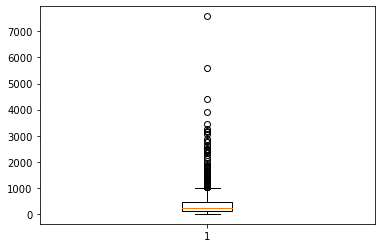

In [4]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

Mean: 402.1701244813278 
Median: 251.0 
Std: 516.6792066581842 


{'whiskers': [<matplotlib.lines.Line2D at 0x271daf6fcf8>,
 'caps': [<matplotlib.lines.Line2D at 0x271daf7d470>,
 'boxes': [<matplotlib.lines.Line2D at 0x271daf6fba8>],
 'medians': [<matplotlib.lines.Line2D at 0x271daf7db70>],
 'fliers': [<matplotlib.lines.Line2D at 0x271daf7de80>],
 'means': []}

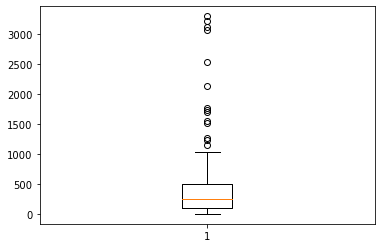

In [5]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

In [6]:
train_df.priority.value_counts()

green       549
amber       249
red         110
escalate     39
Name: priority, dtype: int64

In [7]:
test_df.priority.value_counts()

green       166
amber        47
red          27
escalate      1
Name: priority, dtype: int64

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Initial model creation without using test set

In [9]:
features = vectorizer.fit_transform(train_df.text)
test_features = vectorizer.transform(test_df.text)

In [10]:
features.shape

(947, 5379)

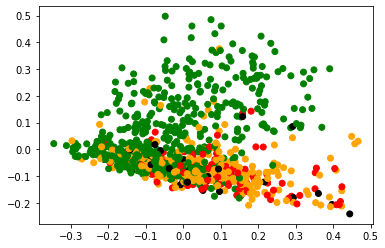

In [11]:
dense_features = features.todense()

pca = PCA(n_components=2).fit(dense_features)

features_2d = pca.transform(dense_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [12]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=-1,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

searched_clf = clf.fit(features, train_df.priority)

print('Best Params:', searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', searched_clf.best_score_, '\n')
print(searched_clf.best_estimator_, '\n')


# searched_clf = SVC(C=8.092008104321838, break_ties=False, cache_size=200,
#     class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
#     gamma=0.02452855456996769, kernel='rbf', max_iter=-1, probability=False,
#     random_state=None, shrinking=True, tol=0.001, verbose=False) 


Best Params: {'C': 13.442864962607775, 'class_weight': 'balanced', 'gamma': 0.018953940227500923, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.5084973536244813 

SVC(C=13.442864962607775, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.018953940227500923, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Wall time: 23.4 s


# Main method to fit and test classifier

In [13]:
def run_tfidf_svc(clf, xtest, ytest):
    
    predicted_priority = clf.predict(xtest)

    print('Classification Report:\n', classification_report(ytest, predicted_priority))
    
    return predicted_priority
    
    

# Train and test on full datasets

In [14]:
predicted_priority = run_tfidf_svc(clf = searched_clf.best_estimator_,
                                   xtest = test_features,
                                   ytest = test_df.priority)

Classification Report:
               precision    recall  f1-score   support

       amber       0.52      0.66      0.58        47
    escalate       0.00      0.00      0.00         1
       green       0.95      0.85      0.90       166
         red       0.55      0.63      0.59        27

    accuracy                           0.78       241
   macro avg       0.50      0.53      0.52       241
weighted avg       0.82      0.78      0.80       241



## Official - ignoring 'green' priority

In [15]:
print('Macro avgd f1 score: ',
      f1_score(test_df.priority,
               predicted_priority, 
               labels=['escalate', 'red', 'amber'],
               average='macro'))

Macro avgd f1 score:  0.38854871629605753


## Flagged - 'crisis + red + amber' as flagged vs 'green'

In [16]:
def map_flagged(label):
    if label in ['escalate', 'red', 'amber']:
        return 'flagged'
    elif label == 'green':
        return 'green'

flagged_ytest = list(map(map_flagged, test_df.priority))
flagged_predictions = list(map(map_flagged, predicted_priority))

print('Classification Report:\n', classification_report(flagged_ytest, flagged_predictions))

Classification Report:
               precision    recall  f1-score   support

     flagged       0.73      0.91      0.81        75
       green       0.95      0.85      0.90       166

    accuracy                           0.87       241
   macro avg       0.84      0.88      0.85       241
weighted avg       0.88      0.87      0.87       241



## Urgent - 'red + escalate' as urgent vs 'amber + green' as non_urgent

In [17]:
def map_urgent(label):
    if label in ['escalate', 'red']:
        return 'urgent'
    elif label in ['green', 'amber']:
        return 'non-urgent'

urgent_ytest = list(map(map_urgent, test_df.priority))
urgent_predictions = list(map(map_urgent, predicted_priority))

print('Classification Report:\n', classification_report(urgent_ytest, urgent_predictions))

Classification Report:
               precision    recall  f1-score   support

  non-urgent       0.96      0.94      0.95       213
      urgent       0.61      0.71      0.66        28

    accuracy                           0.91       241
   macro avg       0.78      0.83      0.80       241
weighted avg       0.92      0.91      0.92       241



# Temp Rough Work

In [18]:
# train_features = vectorizer.fit_transform(train_df.text)

# test_features = vectorizer.transform(test_df[test_df.priority != 'green'].text)

# print(train_features.shape, train_df.priority.shape)
# print(test_features.shape, test_df[test_df.priority != 'green'].priority.shape, '\n')

# svc_clf = SVC(class_weight='balanced')

# print(svc_clf, '\n')

# svc_clf.fit(train_features, train_df.priority)

# predicted_priority = svc_clf.predict(test_features)

# print(classification_report(test_df[test_df.priority != 'green'].priority, predicted_priority))